# Задача о планировании выпуска продукции

 Запас сырья | Количество единиц сырья на единицу продукции A | Количество единиц сырья на единицу продукции B | 
  -------------|-------------|-------------:
  98  | 7 | 1 | 
  34  | 1 | 2 |
  20  | 1 | 1 | 
  **Прибыль от <br> реализации единицы <br> продукции, руб.** | 1 | 2 |

Загрузим библиотеки и данные:

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import linprog
from numpy.linalg import solve
import matplotlib.pyplot as plt
from itertools import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
a = np.array([7, 1, 1])
b = np.array([1, 2, 1])
s = np.array([98, 34, 20])
coefs = [1, 2]

**Решение производится в общем виде**

Переобозначим данные в матричном виде для удобства вычисления:
$$ x = (x_1, \;x_2, \;...)$$
$$ s = (s_1,\; s_2,\; ...)$$
$$ c = (\alpha,\; \beta)$$

Целевая функция:
$$f = \langle c, x \rangle \rightarrow max$$

Матрица коэффициентов:
$$
M =
\begin{pmatrix}
  a1 & b1\\
  a2 & b2\\
  .. & ..\\
\end{pmatrix}
$$

Уравнения ограничений:
$$ \langle M, x \rangle \leq s,\;\; x \geq 0$$

### Геометрическое решение задачи

Создадим матрицу $М$ из исходных данных и будем работать с ней. Решим попарные системы уравнений чтобы найти точки пересечений всех прямых, а затем отсортируем ненужные и построим график. Также проведем несколько линий уровня целевой функции, верхняя из которых оптимальна.

In [3]:
# Добавим в матрицу М строки соответсвующие горизонтальной и вертикальной осям, а также вектор s для удобства
op = np.array([[0, 1, 0],
               [1, 0, 0]])
               
M = np.hstack((a.reshape(-1,1), b.reshape(-1,1), s.reshape(-1,1)))
M = np.vstack((op, M))
M

array([[ 0,  1,  0],
       [ 1,  0,  0],
       [ 7,  1, 98],
       [ 1,  2, 34],
       [ 1,  1, 20]])

Сортируем и строим график

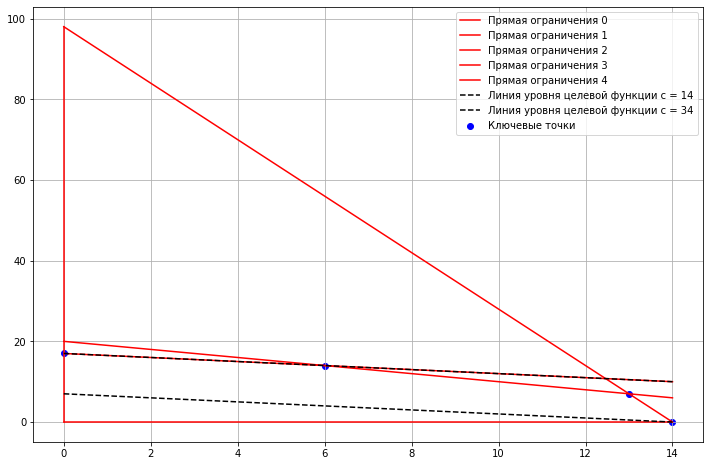

In [4]:
x = pd.DataFrame(columns=['x1', 'x2'])
plt.figure(figsize=(12, 8))


for k, (i, j) in enumerate(combinations(M, 2)):
    x.loc[k, 'x1'], x.loc[k, 'x2'] = solve(np.vstack((i, j))[:, :M.shape[1]-1], np.vstack((i, j))[:, M.shape[1]-1])
plt.grid()
plt.plot(np.linspace(0, 98)*0, np.linspace(0, 98), color='r')

x['r'] = x.x1**2 +x.x2**2
x = x.sort_values('r', ignore_index=True)
x1 = np.array([0, x[x.x2==0].reset_index(drop=True).loc[1, 'x1']])
x2 = np.array([x[x.x1==0].reset_index(drop=True).loc[1, 'x2'], 0])

x1 = np.concatenate((x1, x.loc[(x.x1 !=0) & (x.x2 !=0) & (x.x1 % 1 == 0)].x1.values.astype('float64')))
x2 = np.concatenate((x2, x.loc[(x.x1 !=0) & (x.x2 !=0) & (x.x1 % 1 == 0)].x2.values.astype('float64')))

plt.scatter(x1, x2, color='b', label = 'Ключевые точки')

x1_ = np.linspace(0, max(x1))
for i, row in enumerate(M):
    plt.plot(x1_, (row[2]-row[0]*x1_)/row[1], color = 'r', label = 'Прямая ограничения %d' % i)
cs = coefs[0]*x1 + coefs[1]*x2
for c in [cs.min(), cs.max()]:
    plt.plot(x1_, (c - x1_*coefs[0])/coefs[1], color='black', linestyle='--', label = 'Линия уровня целевой функции с = %d' % c)

plt.legend()

In [5]:
print('Целевая функция: ', cs.max())

Целевая функция:  34.0


Можно отметить, что две точки являются оптимальными решениями: 
$$(0, 17), \;(6, 14).$$

### Симплекс метод

Теперь решим эту же задачу с помощью симплекс метода:

In [6]:
from pulp import *
prob = LpProblem("Задача о планировании выпуска продукции", LpMaximize)
products = LpVariable.dicts("product", ['A', 'B'], lowBound=0, cat='Integer')

costs = dict(zip(products, coefs))
S = []
for i in range(len(a)):
    S.append(dict(zip(products, [a[i], b[i]])))

In [7]:
prob += lpSum([costs[i] * products[i] for i in ['A', 'B']])

for j in range(len(S)):
    prob += lpSum([S[j][i] * products[i] for i in ['A', 'B']]) <= s[j]


In [8]:
prob.solve()
print("Status:", LpStatus[prob.status])

Status: Optimal


In [9]:
funk = 0
for v in prob.variables():
    print(v.name, "=", v.varValue)
    
for i, v in enumerate(prob.variables()):
    funk += v.varValue*coefs[i]
print('Целевая функция: ', funk)

product_A = 0.0
product_B = 17.0
Целевая функция:  34.0


Выходит экономически не выгодно производить продукт $A$ по сравнению с продуктом $B$. Хотя мы можем воспользоватся двумя вариантами планирования, в одном из которых производство продукта $A$ приемлемо. 

**План 1:** A = 0, B = 17 

Запас сырья | Использованного сырья для продукта A | Использованного сырья для продукта B | Остатки сырья
  -------------|-------------|-------------|-------------:
  98  | 0 | 17 | 81
  34  | 0 | 34 | 0
  20  | 0 | 17 | 3 
  **Суммарная прибыль от <br> реализации <br> продукции, руб.** | 0 | 34 |

**План 2:** A = 6, B = 14 

Запас сырья | Использованного сырья для продукта A | Использованного сырья для продукта B | Остатки сырья
  -------------|-------------|-------------|-------------:
  98  | 42 | 14 | 42
  34  | 6 | 28 | 0
  20  | 6 | 14 | 0 
  **Суммарная прибыль от <br> реализации <br> продукции, руб.** | 6 | 28 |

По остаткам сырья нетрудно догадаться, что для плана 1 активным является ограничение на $S_2$, а для плана 2 - на $S_2$ и $S_3$. Это сырье является дефицитным.

Также по остаткам сырья видно, на сколько можно уменьшить запас недефицитного сырья при сохранении полученного оптимального
значения целевой функции.

При увеличении дефецитного сырья $S_2$ вершины (0, 17) и (6, 14), соответсвующие оптимальным планам, стянутся в одну точку (0, 20). Производство увеличится на 3 продукта $B$, значит прибыль вырастет на 6.

Для плана 2 увеличение одного дефецитного сырья прибыли не принесет. Значит наиболее выгодно увеличение запаса сырья $S_2$ при выбранном первом плане. 

### Двойственная задача
$\lambda$ - вектор двойственных переменных.

Целевая функция:
$$f = \langle s, \lambda \rangle \rightarrow min$$
Условия ограничений:
$$\langle M^{T}, \lambda \rangle \geq c, \;\; \lambda \geq 0$$

In [10]:
a = np.array([7, 1, 1, -1, 0])
b = np.array([1, 2, 1, 0, -1])
s = np.array([98, 34, 20, 0, 0])
coefs = [1, 2]

In [11]:
n_lambda = [str(i+1) for i in range(len(a))]

M = np.vstack((a,b)).T
M.T

array([[ 7,  1,  1, -1,  0],
       [ 1,  2,  1,  0, -1]])

In [12]:
prob = LpProblem("Задача о планировании выпуска продукции", LpMinimize)
lambdas = LpVariable.dicts("lambda", n_lambda, lowBound=0, cat='Integer')

costs = dict(zip(lambdas, s))

In [13]:
prob += lpSum([costs[i] * lambdas[i] for i in n_lambda])

for j, row in enumerate(M.T):
    prob += lpSum([row[int(i)-1] * lambdas[i] for i in n_lambda]) >= coefs[j]
    
prob.solve()
print("Status:", LpStatus[prob.status])

Status: Optimal


In [14]:
l = np.array([prob.variables()[i].varValue for i in range(len(prob.variables()))])    
l[3] = 1
for v in prob.variables():
    print(v.name, "=", v.varValue)
print('Целевая функция: ', l @ s)
x1, x2 = solve(M[l>0], s[l>0])
print('x1 = %d, x2 = %d' % (x1, x2))

lambda_1 = 0.0
lambda_2 = 1.0
lambda_3 = 0.0
lambda_4 = 0.0
lambda_5 = 0.0
Целевая функция:  34.0
x1 = 0, x2 = 17


Двойственная задача имеет альтернативное решение. 

Интерпретация двйоственной задачи такова: стоимость сырья, затраченного на производство единицы
продукции, не может быть меньше, чем прибыль от
реализации единицы продукции. 
Значит, при таком плане имеется превышение затрат на ресурсы над ценой реализации.